In [61]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [62]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [63]:
from torchvision import datasets, transforms
data_path = '../data/ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [64]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [65]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [66]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [67]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [68]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [69]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [70]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [71]:
conv = nn.Conv2d(3, 16, kernel_size=3) # equivalent to kernel_size = (3, 3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [72]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [73]:
# nn.Conv2d expects a B x C x H x W shaped tensor as input
# we need to add the zeroth batch dimension with unsqueeze()

img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

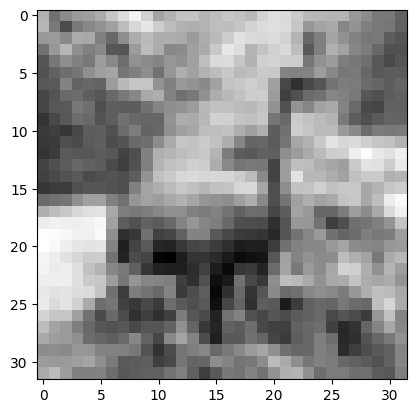

In [74]:
# input bird

plt.imshow(img.mean(0), cmap='gray')
plt.show()

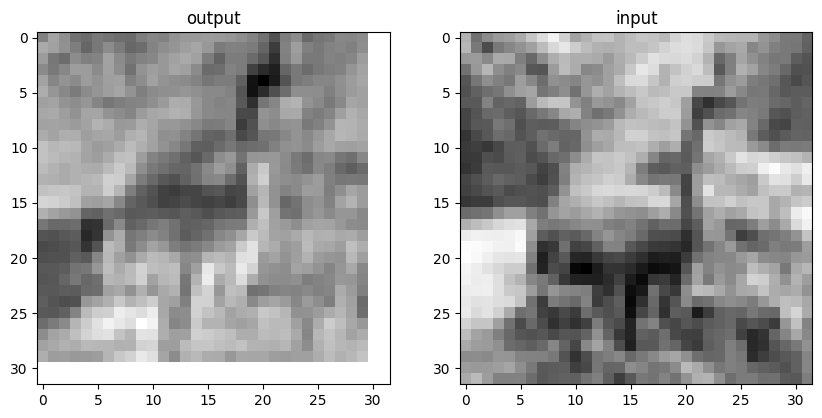

In [75]:
# our bird after a random convolution treatment
# note that we lost two pixels in each dimension

plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

In [76]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # now with zero-padding!
output = conv(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [77]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

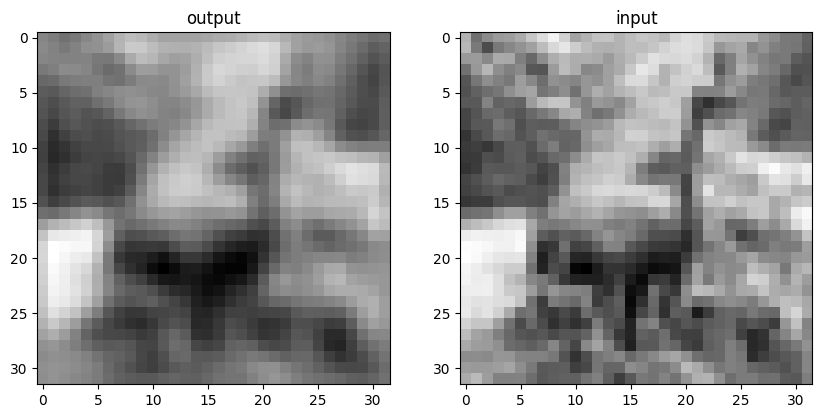

In [78]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [79]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

# It’s an edge-detection kernel: the kernel highlights the
# vertical edge between two horizontally adjacent regions
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

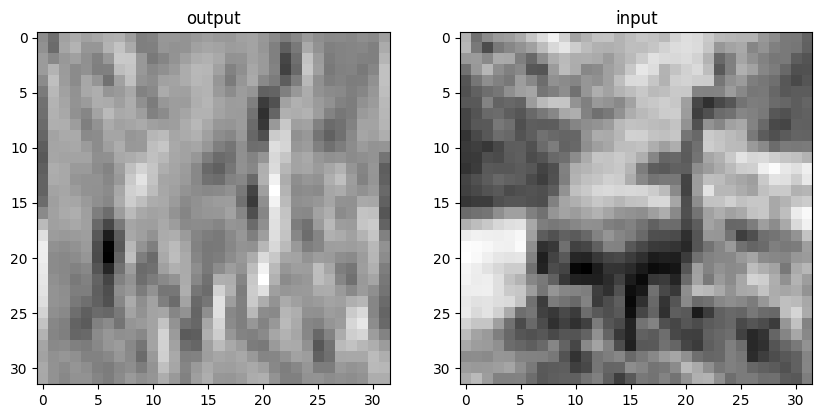

In [80]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()


# Vertical edges throughout our bird, courtesy of a handcrafted convolution kernel

In [81]:
pool = nn.MaxPool2d(2) # max pooling for downsampling
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [82]:
# Putting it all together for our network

model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),          
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [83]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... something important missing here!
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
            )

In [84]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
# We put the warning note in the code for a reason. 
# The model has zero chance of running without complaining:

# What’s missing there is the reshaping step from an 8-channel 8 × 8 image 
# to a 512-element, 1D vector

model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)